Dans ce notebook, nous importons les images de UTKFace Dataset et visualisons le Dataset

In [1]:
from ethicnet import preprocessing
from ethicnet import evaluating
from ethicnet import visualization
from ethicnet import training
from ethicnet import create_datasets

import seaborn as sns

## Visualization

In [2]:
df = preprocessing.extract_infos_from_images_name()
df.head()

,image_name,age,sex,ethnicity
0,33_0_1_20170113134141083.jpg.chip.jpg,33,male,black
1,33_0_3_20170119150501686.jpg.chip.jpg,33,male,indian
2,35_0_2_20170117135233576.jpg.chip.jpg,35,male,asian
3,42_0_3_20170119204253127.jpg.chip.jpg,42,male,indian
4,28_1_3_20170109141400528.jpg.chip.jpg,28,female,indian


In [3]:
df.describe()

,age
count,23708.000000
mean,33.303484
std,19.886112
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


In [4]:
df.ethnicity.value_counts()

white                             10078
black                              4526
indian                             3975
asian                              3434
others                             1692
20170109150557335.jpg.chip.jpg        1
20170116174525125.jpg.chip.jpg        1
20170109142408075.jpg.chip.jpg        1
Name: ethnicity, dtype: int64

Nous avons trois photos où l'ethnicité n'est pas définie

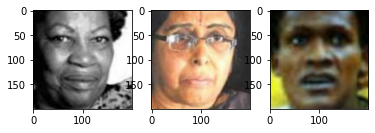

In [5]:
visualization.plot_undefined_ethnicity(df)

Nous attribuons une ethnicité à la main : Black, Indian, Black

In [6]:
preprocessing.correct_undefined_ethnicity(df)

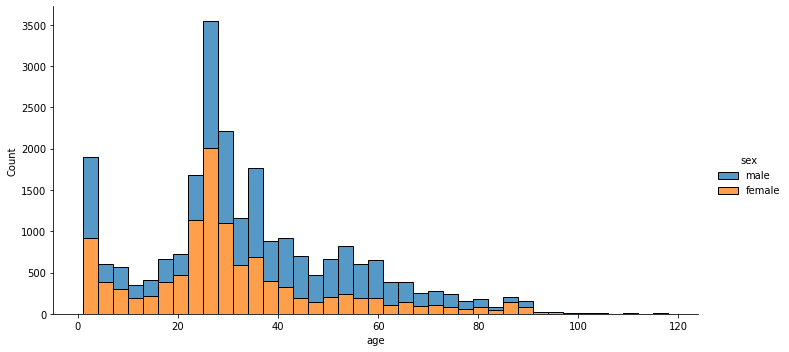

In [7]:
sns.displot(data=df, x="age", binwidth=3, aspect=2, hue = 'sex', multiple="stack")

Il y a beaucoup de personnes de 27 ans. Ce sera à corriger, peut-être en augmentant moins ces images que les autres.

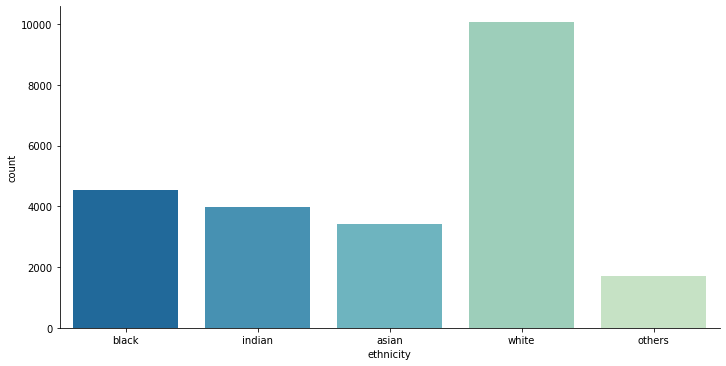

In [8]:
sns.catplot(x="ethnicity", kind="count", palette=sns.color_palette("GnBu_r"),aspect=2, data=df)

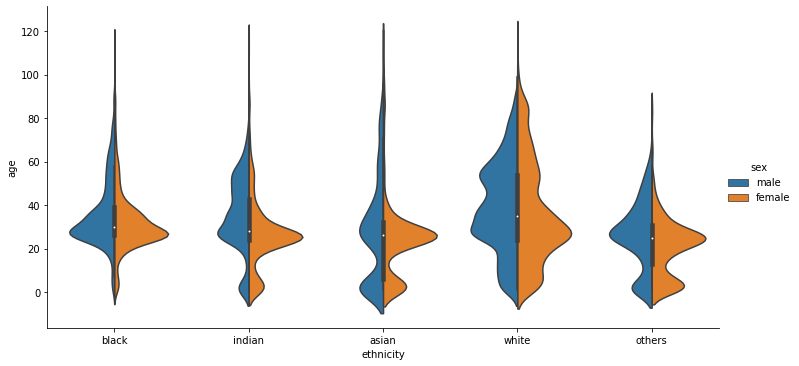

In [10]:
sns.catplot(x="ethnicity", y="age", hue="sex",aspect=2, kind="violin", split=True, data=df)

# AVORTÉ suite aux remarques de Cédric
## Preprocessing

Prédire le sexe des personnes, et voir si le modèle est moins bon pour les différentes ethnicités.

In [24]:
batch_size = 64
image_size=(200,200)

In [13]:
img_ds, labels_ds = create_datasets.paths_and_labels_to_dataset(image_paths = [ config.data_dir + item for item in list(df.image_name) ], 
                                                                image_size = image_size,
                                                                num_channels = 3, 
                                                                labels = [int(item) for item in list(df.sex)], 
                                                                label_mode = 'categorical',
                                                                num_classes = 2, 
                                                                interpolation = 'bilinear',
                                                                smart_resize=False)

In [15]:
image_ds = create_datasets.combine_and_batch_img_label_datasets(img_ds,label_ds,batch_size)

In [17]:
train_ds,val_ds = create_datasets.separate_train_validation(image_ds, ratio = 0.8)

## Training

In [27]:
learning_rate = 1e-3
epochs = 10


In [25]:
model = training.build_model(nb_classes = 2, image_size = image_size, learning_rate = learning_rate, img_augmentation = preprocessing.img_augmentation)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 16, 16, 32)   864         img_augmentation[0][0]           
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 16, 16, 32)   128         stem_conv[0][0]                  
______________________________________________________________________________________________

In [28]:
history = model.fit( train_ds, batch_size=batch_size, epochs=epochs, verbose=1, validation_data = val_ds)

Epoch 1/10
371/371 [==============================] - 321s 864ms/step - loss: 0.8291 - accuracy: 0.5078
Epoch 2/10
371/371 [==============================] - 320s 864ms/step - loss: 0.7543 - accuracy: 0.5170
Epoch 3/10
371/371 [==============================] - 321s 864ms/step - loss: 0.7407 - accuracy: 0.5190
Epoch 4/10
371/371 [==============================] - 322s 867ms/step - loss: 0.7342 - accuracy: 0.5178
Epoch 5/10
371/371 [==============================] - 322s 869ms/step - loss: 0.7345 - accuracy: 0.5147
Epoch 6/10
371/371 [==============================] - 322s 867ms/step - loss: 0.7285 - accuracy: 0.5175
Epoch 7/10
371/371 [==============================] - 322s 868ms/step - loss: 0.7304 - accuracy: 0.5152
Epoch 8/10
371/371 [==============================] - 322s 868ms/step - loss: 0.7282 - accuracy: 0.5222
Epoch 9/10
371/371 [==============================] - 323s 870ms/step - loss: 0.7264 - accuracy: 0.5166
Epoch 10/10
371/371 [==============================] - 323s 870m

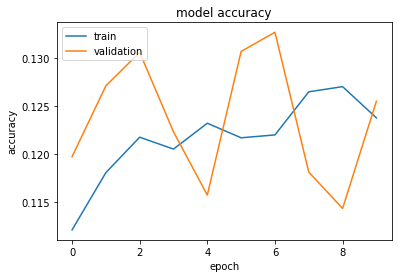

In [15]:
evaluating.plot_hist(history.history)

In [16]:
training.unfreeze_model(model)

In [17]:
history2 = model.fit(X_train, Y_train, epochs=2, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/2
782/782 [==============================] - 44s 50ms/step - loss: 2.2996 - accuracy: 0.1357 - val_loss: 2.2694 - val_accuracy: 0.1475
Epoch 2/2
782/782 [==============================] - 38s 49ms/step - loss: 2.2907 - accuracy: 0.1407 - val_loss: 2.2719 - val_accuracy: 0.1437


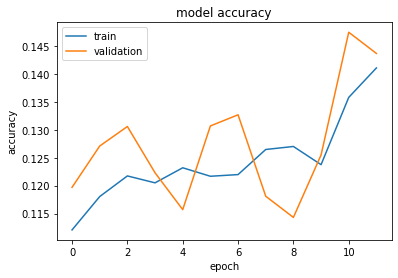

In [27]:
evaluating.plot_global_history(history.history,history2.history)